In [102]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [103]:
biogrid = pd.read_csv('BIOGRID2.tab.txt', sep='\t')


In [104]:
biogrid.head()

,OFFICIAL_SYMBOL_A,OFFICIAL_SYMBOL_B
0,MAP2K4,FLNC
1,MYPN,ACTN2
2,ACVR1,FNTA
3,GATA2,PML
4,RPA2,STAT3


In [ ]:
genesA = biogrid['OFFICIAL_SYMBOL_A'].tolist()
genesB = biogrid['OFFICIAL_SYMBOL_B'].tolist()
genes = genesA + genesB
genes = list(dict.fromkeys(genes))


In [118]:
def sort_genes(snp, genes):
    snp = snp[['uniqID', 'rsID', 'gwasP']].dropna()
    snp = snp.sort_values(by='gwasP')
    genes= genes[['uniqID','symbol']].dropna()

    merged = pd.merge(snp, genes, on='uniqID', how='left').dropna()
    merged = merged.drop_duplicates(subset='symbol')
    merged.reset_index(inplace=True, drop=True)

    print('Number of genes in gene set: ', len(merged))
    return merged


In [119]:
endometriosis = sort_genes(pd.read_csv('FUMA_dowloads_all_tissue/SNPs/snps_ENDOMETRIOSIS.txt', sep='\t'), pd.read_csv('FUMA_dowloads_all_tissue/eQTL/eqtl_ENDOMETRIOSIS.txt',sep='\t') )

Number of genes in gene set:  102


In [ ]:
endometriosis.head(50)

In [108]:
G = nx.Graph()

for index, row in biogrid.iterrows():
    source_node = row['OFFICIAL_SYMBOL_A']
    target_node = row['OFFICIAL_SYMBOL_B']
       
    G.add_edge(source_node, target_node)

In [ ]:
G.degree['CDC42']


In [116]:
def mst(gene_set, n):    

    nodes = gene_set['symbol'].tolist()
    #select top n genes 
    subset_of_nodes = nodes[:n]

    # Create a new graph to store the shortest paths
    H = nx.Graph()

    # Find the shortest path between each pair of nodes in the subset
    for i in range(len(subset_of_nodes)):
        for j in range(i + 1, len(subset_of_nodes)):
            node_i = subset_of_nodes[i]
            node_j = subset_of_nodes[j]
            
            # Check if both nodes exist in graph G
            if node_i in G and node_j in G:
                try:
                    # Calculate shortest path if nodes exist in G
                    path = nx.shortest_path(G, node_i, node_j)
                    if len(path) <= 4:
                        #print(path)
                        path_edges = [(path[k], path[k+1]) for k in range(len(path)-1)]
                        #print(path_edges)
                        H.add_edges_from(path_edges)
                except nx.NetworkXNoPath:
                    continue
            else:
                continue

    # Find the minimum spanning tree of the new graph
    mst = nx.minimum_spanning_tree(H, algorithm='kruskal')

    # Find the leaves (outermost nodes) in the MST
    leaves = [node for node, degree in mst.degree() if degree == 1]

    # Prune the MST by removing the leaves
    pruned_mst = mst.copy()  # Make a copy to avoid modifying the original MST
    pruned_mst.remove_nodes_from(leaves)

    # Calculate node colors for the original MST
    node_colors_mst = ['skyblue' if node in subset_of_nodes else 'lightgreen' for node in mst.nodes]

    # Calculate node colors for the pruned MST
    node_colors_pruned = ['skyblue' if node in subset_of_nodes else 'lightgreen' for node in pruned_mst.nodes]

    # Set up the figure with subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Plot the original MST
    axs[0].set_title("Original Minimum Spanning Tree")
    pos_mst = nx.spring_layout(mst, seed=42)
    nx.draw_networkx_nodes(mst, pos_mst, node_size=1000, node_color=node_colors_mst, ax=axs[0])
    nx.draw_networkx_edges(mst, pos_mst, edge_color='red', width=2, ax=axs[0])
    nx.draw_networkx_labels(mst, pos_mst, font_size=10, font_color='black', font_family='sans-serif', ax=axs[0])
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    # Plot the pruned MST
    axs[1].set_title("Pruned Minimum Spanning Tree")
    pos_pruned = nx.spring_layout(pruned_mst, seed=42)
    nx.draw_networkx_nodes(pruned_mst, pos_pruned, node_size=1000, node_color=node_colors_pruned, ax=axs[1])
    nx.draw_networkx_edges(pruned_mst, pos_pruned, edge_color='red', width=2, ax=axs[1])
    nx.draw_networkx_labels(pruned_mst, pos_pruned, font_size=10, font_color='black', font_family='sans-serif', ax=axs[1])
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()



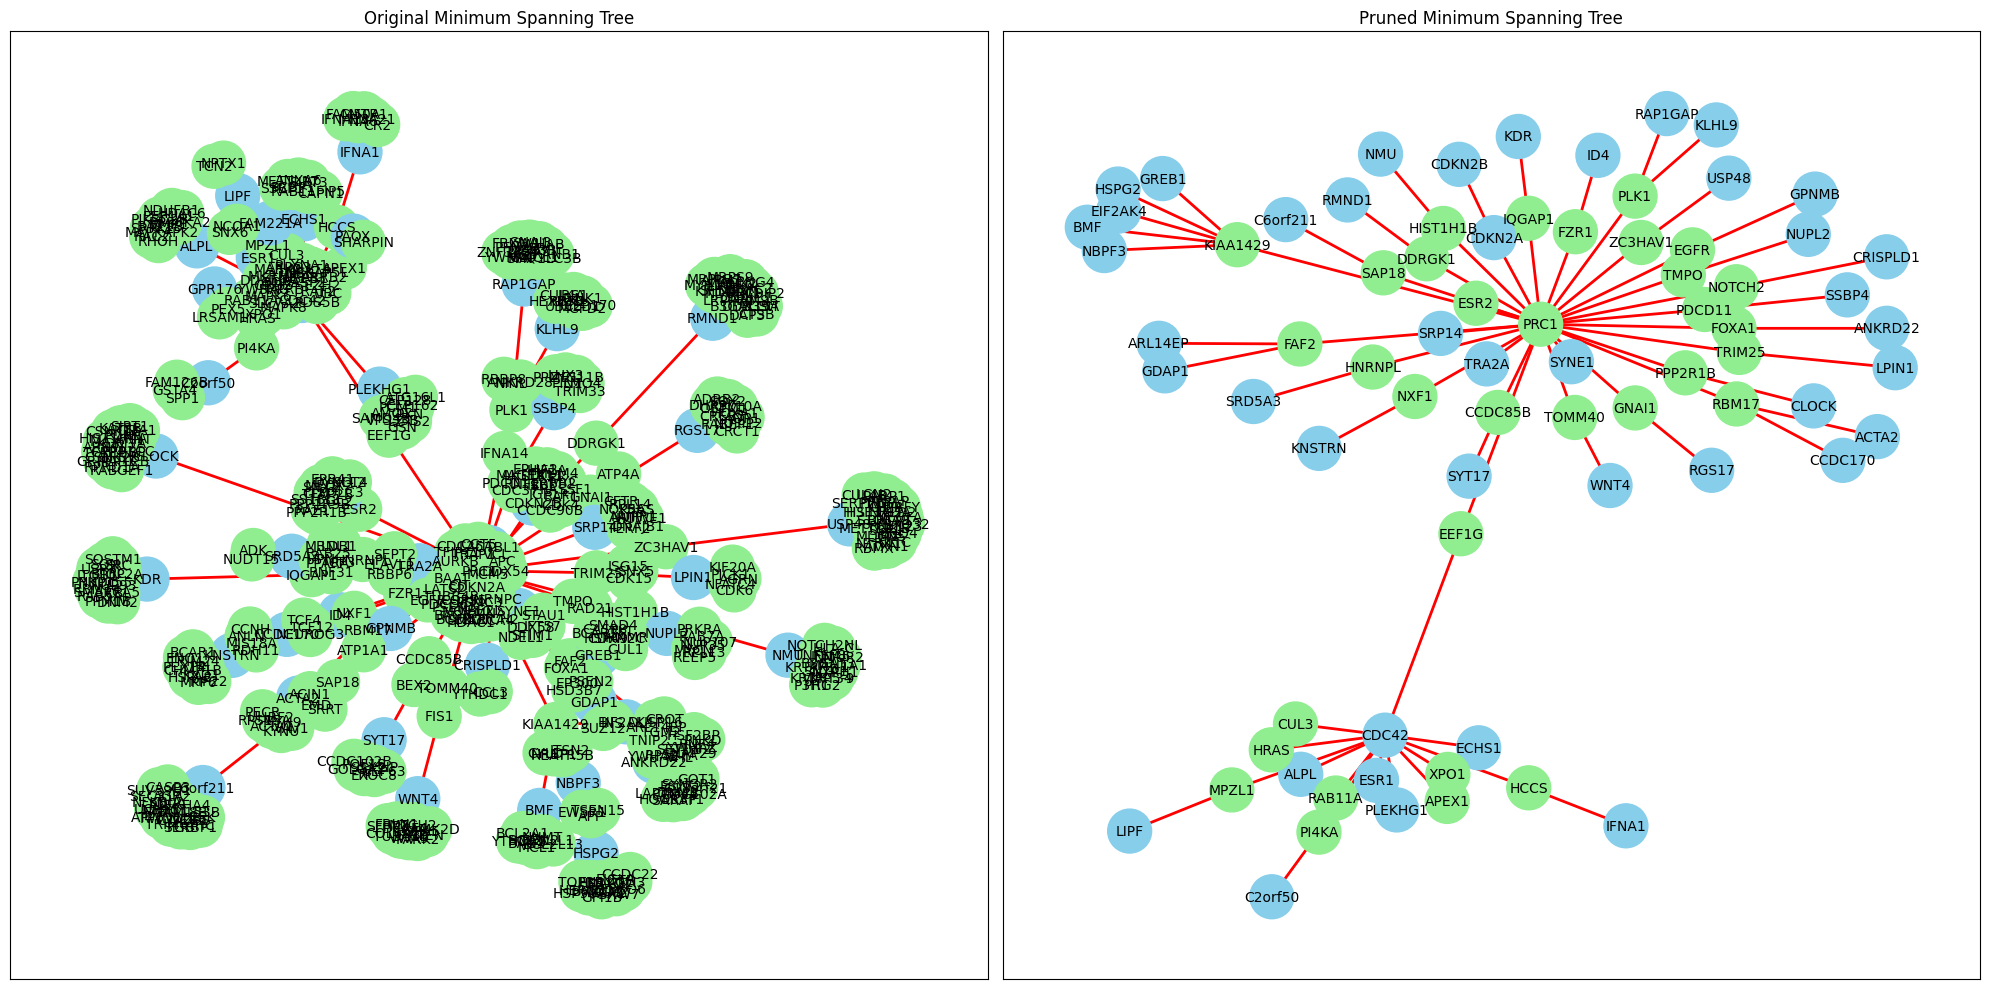

In [117]:
mst(endometriosis, 50)